In [1]:
import pandas as pd
import numpy as np
import scipy
from lightfm.data import Dataset
from lightfm import LightFM
from matplotlib import pyplot as plt
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import reciprocal_rank

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Data Load and Preprocessing

In [2]:
data1 = pd.read_csv('D:\\GitHub\\Airbnb\\Feature Mapping + Sentiment\\Final_Reviewer_Scores.csv', error_bad_lines=False, encoding='latin-1')
data2 = pd.read_csv('D:\\GitHub\\Airbnb\\Feature Mapping + Sentiment\\temp_overall.csv', error_bad_lines=False)

In [3]:
data = pd.merge(data1,data2, how = "inner", on = ["listing_id", "reviewer_id"])

In [4]:
data.head()
#len(data)

,listing_id,reviewer_id,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
0,35644,5394983,NaN,0.91525,0.9371,0.5115,-0.29600,NaN,0.8225,0.58925
1,35644,3712269,NaN,0.82710,0.8271,0.8271,0.54130,NaN,NaN,0.59010
2,35644,2908896,NaN,NaN,NaN,NaN,0.61850,NaN,NaN,0.64045
3,35644,3941752,0.5719,0.30890,0.5106,NaN,0.91000,0.5719,NaN,0.57535
4,35644,2735578,NaN,NaN,NaN,NaN,0.82475,NaN,0.8479,0.82475


In [5]:
data.pivot(index = 'reviewer_id', columns ='listing_id', values = 'overall_avg')

listing_id,35644,38951,84581,88873,137808,162081,252996,268482,270374,278045,...,29781455,29786280,29788062,29814969,29826978,29903362,29929970,29946329,29951405,30004534
reviewer_id,,,,,,,,,,,,,,,,,,,,,
1510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Count number of feature wise scores available for each reviewer in order to create a user profile based on faetures
user_profile = pd.DataFrame({'reviewer_id':data.reviewer_id.unique()})
loop = ["experience","view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food"]
for i in range(len(loop)):
    non_zero = data.loc[data[loop[i]]!=0]
    data_grouped = non_zero.groupby('reviewer_id')[loop[i]].apply(lambda x: pd.Series([x.count()])).unstack()
    print(i)
    user_profile = pd.merge(user_profile,data_grouped[0], how = 'left', on = 'reviewer_id')

0
1
2
3
4
5
6


In [5]:
user_profile.columns = ['reviewer_id',"experience","view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food"]

In [6]:
#If available count of feature score > 0 for a user, update with feature name (for input to lightfm), else 0
user_profile_agg = user_profile
loop = ["experience","view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food"]
for i in range(len(loop)):
    user_profile_agg.loc[user_profile_agg[loop[i]]>0,loop[i]] = loop[i]

In [7]:
user_profile_agg = user_profile_agg.fillna(0)
user_profile_agg.head()

,reviewer_id,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food
0,5394983,0,view,décor_and_amenities,neighborhood_and_access,host,0,food
1,3712269,0,view,décor_and_amenities,neighborhood_and_access,host,0,0
2,2908896,0,0,0,0,host,0,0
3,3941752,experience,view,décor_and_amenities,0,host,weather_and_amenties,0
4,2735578,0,view,décor_and_amenities,neighborhood_and_access,host,0,food


In [8]:
#Calculate feature wise score for each listing
listing_data = pd.DataFrame({'listing_id':data.listing_id.unique()})
loop = ["experience","view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food","overall_avg"]
for i in range(len(loop)):
    data_grouped = data.groupby('listing_id')[loop[i]].apply(lambda x: pd.Series([(x < 0).sum(),(x > 0).sum()])).unstack()
    data_grouped['perc']=(data_grouped[1]-data_grouped[0])/(data_grouped[1]+data_grouped[0])
    print(i)
    listing_data = pd.merge(listing_data, data_grouped, how = 'left', on = 'listing_id')

0
1
2
3
4
5
6
7


In [11]:
listing_data.head()

,listing_id,0_x,1_x,perc_x,0_y,1_y,perc_y,0_x,1_x,perc_x,...,perc_x,0_y,1_y,perc_y,0_x,1_x,perc_x,0_y,1_y,perc_y
0,35644,1,65,0.969697,1,130,0.984733,1,171,0.988372,...,0.950000,0,60,1.000000,0,46,1.000000,3,198,0.970149
1,38951,0,30,1.000000,0,54,1.000000,3,105,0.944444,...,0.959184,3,36,0.846154,1,15,0.875000,0,135,1.000000
2,84581,0,5,1.000000,0,14,1.000000,0,13,1.000000,...,1.000000,0,7,1.000000,0,1,1.000000,0,16,1.000000
3,88873,2,25,0.851852,3,78,0.925926,7,235,0.942149,...,0.963636,5,63,0.852941,3,41,0.863636,2,296,0.986577
4,137808,0,11,1.000000,2,20,0.818182,3,118,0.950413,...,0.829787,5,18,0.565217,2,10,0.666667,4,139,0.944056


In [9]:
#Combine orig listings data and new feature scores
orig_data = pd.read_csv('D:\\GitHub\\Airbnb\\Recommendation\\Tasmania-detailed listings - final2.csv', error_bad_lines=False)
listing_profile = pd.merge(orig_data, listing_data, how = 'left', on = 'listing_id')

In [10]:
#Rename columns and extract only the necessary ones
listing_profile.columns = ['listing_id','host_is_superhost','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','price','security_deposit (% of price)','cleaning_fee (% of price)','minimum_nights','cancellation_policy',
"experience_p","experience_n","experience","view_p","view_n","view","décor_and_amenities_p","décor_and_amenities_n","décor_and_amenities",
"neighborhood_and_access_p","neighborhood_and_access_n","neighborhood_and_access","host_p","host_n","host",
"weather_and_amenties_p","weather_and_amenties_n","weather_and_amenties","food_p","food_n","food","overall_avg_p","overall_avg_n","overall_avg"]
features = ['listing_id','host_is_superhost','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','price','security_deposit (% of price)','cleaning_fee (% of price)','minimum_nights','cancellation_policy',
"experience","view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food","overall_avg"]
listing_profile = listing_profile[features]

In [14]:
listing_profile.head()

,listing_id,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,minimum_nights,cancellation_policy,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
0,35644,t,Hobart,House,Private room,2,1.5,1,1,Real Bed,...,1,moderate,0.969697,0.984733,0.988372,0.974359,0.950000,1.000000,1.000000,0.970149
1,38951,t,Hobart,Townhouse,Entire home/apt,4,1.0,2,2,Real Bed,...,2,strict_14_with_grace_period,1.000000,1.000000,0.944444,0.983740,0.959184,0.846154,0.875000,1.000000
2,84581,f,Kentish,House,Entire home/apt,9,2.0,3,6,Real Bed,...,2,strict_14_with_grace_period,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,88873,t,Hobart,Townhouse,Entire home/apt,4,1.0,2,3,Real Bed,...,1,moderate,0.851852,0.925926,0.942149,0.961240,0.963636,0.852941,0.863636,0.986577
4,137808,f,Launceston,House,Entire home/apt,9,1.5,2,7,Real Bed,...,1,strict_14_with_grace_period,1.000000,0.818182,0.950413,0.882353,0.829787,0.565217,0.666667,0.944056


In [224]:
listing_profile.to_csv('D:\\GitHub\\Airbnb\\Recommendation\\Tasmania-FinalDataset.csv')

In [ ]:
#TODO:Train and test split
#     Check if dimensions of train, test, user sp matrix and item sp matrix are as expected
#     Create listings df with buckets for numerical columns

In [15]:
listing_profile_text.columns

NameError: name 'listing_profile_text' is not defined

In [11]:
#Pre-process listing features for lightfm

#Drop unwanted columns and convert price related columns to float type
listing_profile_text = listing_profile
listing_profile_text = listing_profile_text.drop(['neighbourhood_cleansed'], axis=1 )
listing_profile_text.price = listing_profile_text.price.str[1:].replace(',','', regex=True).astype(float)
listing_profile_text['security_deposit (% of price)'] = listing_profile_text['security_deposit (% of price)'].str[1:].replace(',','', regex=True).replace('%','', regex=True).astype(float)
listing_profile_text['cleaning_fee (% of price)'] = listing_profile_text['cleaning_fee (% of price)'].str[1:].replace(',','', regex=True).replace('%','', regex=True).astype(float)

(array([3.017e+03, 1.732e+03, 2.020e+02, 5.900e+01, 2.800e+01, 1.200e+01,
        1.100e+01, 5.000e+00, 3.000e+00, 4.000e+00]),
 array([  15. ,  163.5,  312. ,  460.5,  609. ,  757.5,  906. , 1054.5,
        1203. , 1351.5, 1500. ]),
 <a list of 10 Patch objects>)

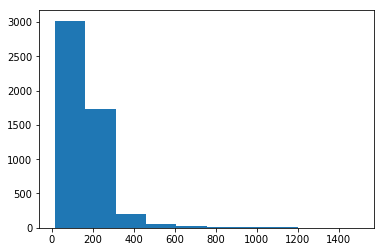

In [12]:
plt.hist(listing_profile_text.price) #4 bins

(array([4.993e+03, 6.200e+01, 3.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 5.000e+00, 4.000e+00, 1.000e+00]),
 array([  0.   ,  87.597, 175.194, 262.791, 350.388, 437.985, 525.582,
        613.179, 700.776, 788.373, 875.97 ]),
 <a list of 10 Patch objects>)

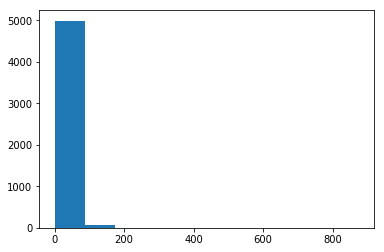

In [385]:
plt.hist(listing_profile_text['security_deposit (% of price)']) #4 bins

(array([4.983e+03, 8.100e+01, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.  ,  9.62, 19.24, 28.86, 38.48, 48.1 , 57.72, 67.34, 76.96,
        86.58, 96.2 ]),
 <a list of 10 Patch objects>)

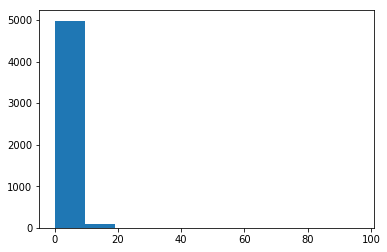

In [386]:
plt.hist(listing_profile_text['cleaning_fee (% of price)']) #4 bins

In [24]:
#plt.hist(listing_profile_text.accommodates) #6 bins
#plt.hist(listing_profile_text.bathrooms) #4 bins
#plt.hist(listing_profile_text.bedrooms) #6 bins
#plt.hist(listing_profile_text.beds) #6 bins
listing_profile_text.describe()

,listing_id,accommodates,bathrooms,bedrooms,beds,price,security_deposit (% of price),cleaning_fee (% of price),minimum_nights,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
count,5.073000e+03,5073.000000,5073.000000,5073.000000,5073.000000,5073.000000,5073.000000,5073.000000,5073.000000,3419.000000,4021.000000,4195.000000,4192.000000,3936.000000,3550.000000,3413.000000,4297.000000
mean,1.736545e+07,4.484723,1.314902,1.923122,3.038636,170.126552,9.058179,2.298317,1.759905,0.978993,0.976719,0.974072,0.971147,0.961766,0.877388,0.925906,0.980356
std,8.062253e+06,2.630845,0.600127,1.335042,3.470880,119.321419,39.286497,3.842917,2.610098,0.128465,0.094084,0.105714,0.105349,0.163314,0.283938,0.256541,0.091077
min,3.564400e+04,1.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.117233e+07,2.000000,1.000000,1.000000,1.000000,101.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.978201,1.000000,0.857143,1.000000,1.000000
50%,1.835965e+07,4.000000,1.000000,2.000000,2.000000,150.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.348213e+07,6.000000,1.500000,3.000000,4.000000,200.000000,0.000000,4.440000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.018398e+07,16.000000,8.000000,48.000000,50.000000,1500.000000,875.970000,96.200000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
listing_profile_text = listing_profile_text.fillna(0)

In [14]:
listing_profile_text.isnull().values.any()

False

In [15]:
#Pre-process listing features for lightfm

#Bin numerical values into categorical form
bins = [0, 200, 400, 600, 1500]
labels = ['Price_Bin_'+str(i) for i in range(1,5)]
listing_profile_text.price = pd.cut(listing_profile_text.price,bins, labels = labels)
listing_profile_text.price = listing_profile_text.price.astype(object)

bins = [-1, 0, 1, 100,200, 876]
labels = ['Security_Bin_'+str(i) for i in range(1,6)]
listing_profile_text['security_deposit (% of price)'] = pd.cut(listing_profile_text['security_deposit (% of price)'],bins, labels = labels)
listing_profile_text['security_deposit (% of price)'] = listing_profile_text['security_deposit (% of price)'].astype(object)

bins = [-1, 0, 1, 20, 50, 100]
labels = ['Cleaning_Bin_'+str(i) for i in range(1,6)]
listing_profile_text['cleaning_fee (% of price)'] = pd.cut(listing_profile_text['cleaning_fee (% of price)'],bins, labels = labels)
listing_profile_text['cleaning_fee (% of price)'] = listing_profile_text['cleaning_fee (% of price)'].astype(object)

bins = [0, 2, 4, 6, 8, 10, 16]
labels = ['Accommodates_Bin_'+str(i) for i in range(1,7)]
listing_profile_text.accommodates = pd.cut(listing_profile_text.accommodates,bins, labels = labels)
listing_profile_text.accommodates = listing_profile_text.accommodates.astype(object)

bins = [-1,0, 1, 2, 3, 10]
labels = ['Bathrooms_Bin_'+str(i) for i in range(1,6)]
listing_profile_text.bathrooms = pd.cut(listing_profile_text.bathrooms,bins, labels = labels)
listing_profile_text.bathrooms = listing_profile_text.bathrooms.astype(object)

bins = [-1,0, 1, 2, 3, 5, 52]
labels = ['Bedrooms_Bin_'+str(i) for i in range(1,7)]
listing_profile_text.bedrooms = pd.cut(listing_profile_text.bedrooms,bins, labels = labels)
listing_profile_text.bedrooms = listing_profile_text.bedrooms.astype(object)

bins = [0, 1, 2, 3, 5, 50]
labels = ['Beds_Bin_'+str(i) for i in range(1,6)]
listing_profile_text.beds = pd.cut(listing_profile_text.beds,bins, labels = labels)
listing_profile_text.beds = listing_profile_text.beds.astype(object)

bins = [0, 1, 2, 120]
labels = ['Min_Nights_Bin_'+str(i) for i in range(1,4)]
listing_profile_text.minimum_nights = pd.cut(listing_profile_text.minimum_nights,bins, labels = labels)
listing_profile_text.minimum_nights = listing_profile_text.minimum_nights.astype(object)

fs = ['experience',"view","décor_and_amenities","neighborhood_and_access","host","weather_and_amenties","food","overall_avg"]

for f in fs:
    bins = [-1.5, 0, 1]
    labels = ['no',f]
    listing_profile_text[f] = pd.cut(listing_profile_text[f],bins, labels = labels)
    listing_profile_text[f] = listing_profile_text[f].astype(object)

In [16]:
listing_profile_text.isnull().values.any()

False

In [22]:
df = listing_profile_text[listing_profile_text.isna().any(axis=1)]
df

,listing_id,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,...,minimum_nights,cancellation_policy,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
7,268482,t,Bed and breakfast,Private room,Accommodates_Bin_1,Bathrooms_Bin_1,NaN,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,super_strict_30,no,no,décor_and_amenities,no,no,weather_and_amenties,no,overall_avg
15,401176,f,House,Private room,Accommodates_Bin_1,NaN,Bedrooms_Bin_1,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
61,877502,f,House,Private room,Accommodates_Bin_1,NaN,Bedrooms_Bin_1,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,flexible,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
114,1525866,f,Guesthouse,Entire home/apt,Accommodates_Bin_2,Bathrooms_Bin_1,NaN,Beds_Bin_2,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
119,1583902,f,Apartment,Entire home/apt,Accommodates_Bin_1,Bathrooms_Bin_1,NaN,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
141,1824421,t,Condominium,Entire home/apt,Accommodates_Bin_1,Bathrooms_Bin_1,NaN,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,flexible,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
166,2063767,t,Camper/RV,Entire home/apt,Accommodates_Bin_1,NaN,Bedrooms_Bin_2,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
177,2131356,f,Apartment,Entire home/apt,Accommodates_Bin_3,Bathrooms_Bin_1,NaN,Beds_Bin_3,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
178,2131468,f,Apartment,Entire home/apt,Accommodates_Bin_3,Bathrooms_Bin_1,NaN,Beds_Bin_3,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
197,2256587,f,Tiny house,Entire home/apt,Accommodates_Bin_1,Bathrooms_Bin_1,NaN,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg


In [17]:
listing_profile_text.head()

,listing_id,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,...,minimum_nights,cancellation_policy,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
0,35644,t,House,Private room,Accommodates_Bin_1,Bathrooms_Bin_3,Bedrooms_Bin_2,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
1,38951,t,Townhouse,Entire home/apt,Accommodates_Bin_2,Bathrooms_Bin_2,Bedrooms_Bin_3,Beds_Bin_2,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
2,84581,f,House,Entire home/apt,Accommodates_Bin_5,Bathrooms_Bin_3,Bedrooms_Bin_4,Beds_Bin_5,Real Bed,Price_Bin_2,...,Min_Nights_Bin_2,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
3,88873,t,Townhouse,Entire home/apt,Accommodates_Bin_2,Bathrooms_Bin_2,Bedrooms_Bin_3,Beds_Bin_3,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
4,137808,f,House,Entire home/apt,Accommodates_Bin_5,Bathrooms_Bin_3,Bedrooms_Bin_3,Beds_Bin_5,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg


In [620]:
listing_profile_text.dtypes

listing_id                        int64
host_is_superhost                object
property_type                    object
room_type                        object
accommodates                     object
bathrooms                        object
bedrooms                         object
beds                             object
bed_type                         object
price                            object
security_deposit (% of price)    object
cleaning_fee (% of price)        object
minimum_nights                   object
cancellation_policy              object
experience                       object
view                             object
décor_and_amenities              object
neighborhood_and_access          object
host                             object
weather_and_amenties             object
food                             object
overall_avg                      object
dtype: object

In [18]:
#Extract only text columns
text_c = []
for c in listing_profile_text.columns:
    if(listing_profile_text[c].dtypes == 'object'):
        text_c.append(c)
text_c

['host_is_superhost',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'security_deposit (% of price)',
 'cleaning_fee (% of price)',
 'minimum_nights',
 'cancellation_policy',
 'experience',
 'view',
 'décor_and_amenities',
 'neighborhood_and_access',
 'host',
 'weather_and_amenties',
 'food',
 'overall_avg']

# LightFM

In [19]:
#Create lightfm dataset using reviewer id and listing id
dataset = Dataset()
dataset.fit((user_profile_agg['reviewer_id']),
            (listing_profile_text['listing_id']))
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 125747, num_items 5073.


In [20]:
#Create interaction matrix by passing computed overall score as weights
(interactions, weights) = dataset.build_interactions(((data.loc[i,'reviewer_id'],data.loc[i,'listing_id'],1 if data.loc[i,'overall_avg']>0 else 0)
                                                      for i in range(0,len(data))))
print(repr(interactions))

<125747x5073 sparse matrix of type '<class 'numpy.int32'>'
	with 177723 stored elements in COOrdinate format>


In [21]:
#Create list of all possible unique feature values for listings
temp_list = []
for c in listing_profile_text.iloc[:,1:]:
    print(listing_profile_text[c].unique())
    temp_loop = list(listing_profile_text[c].unique())
    for x in temp_loop:
        if(x != "no"):
            temp_list.append(x)

['t' 'f']
['House' 'Townhouse' 'Guest suite' 'Bed and breakfast' 'Loft' 'Guesthouse'
 'Apartment' 'Bungalow' 'Cabin' 'Cottage' 'Chalet' 'Earth house'
 'Condominium' 'Farm stay' 'Other' 'Serviced apartment' 'Treehouse'
 'Camper/RV' 'Boutique hotel' 'Tiny house' 'Barn' 'Nature lodge' 'Villa'
 'Tipi' 'Hostel' 'Castle' 'Hut' 'Hotel' 'Yurt' 'Tent' 'Island' 'Bus'
 'Aparthotel' 'Casa particular (Cuba)' 'Dome house' 'Campsite'
 'Vacation home' 'Boat']
['Private room' 'Entire home/apt' 'Shared room']
['Accommodates_Bin_1' 'Accommodates_Bin_2' 'Accommodates_Bin_5'
 'Accommodates_Bin_6' 'Accommodates_Bin_3' 'Accommodates_Bin_4']
['Bathrooms_Bin_3' 'Bathrooms_Bin_2' 'Bathrooms_Bin_1' 'Bathrooms_Bin_5'
 'Bathrooms_Bin_4']
['Bedrooms_Bin_2' 'Bedrooms_Bin_3' 'Bedrooms_Bin_4' 'Bedrooms_Bin_1'
 'Bedrooms_Bin_5' 'Bedrooms_Bin_6']
['Beds_Bin_1' 'Beds_Bin_2' 'Beds_Bin_5' 'Beds_Bin_3' 'Beds_Bin_4']
['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed']
['Price_Bin_1' 'Price_Bin_2' 'Price_Bin_3' 'Price_Bin_4']
['Sec

In [22]:
temp_list = list(set(temp_list)) #To remove multiple "no"
temp_list

['Serviced apartment',
 'Beds_Bin_4',
 'Bedrooms_Bin_2',
 'Beds_Bin_5',
 'Cleaning_Bin_4',
 'Townhouse',
 'Campsite',
 'Bedrooms_Bin_4',
 'Price_Bin_3',
 'Pull-out Sofa',
 'Guest suite',
 'Treehouse',
 'Accommodates_Bin_6',
 'Security_Bin_3',
 'neighborhood_and_access',
 'Bathrooms_Bin_4',
 'Accommodates_Bin_1',
 'Accommodates_Bin_3',
 'Private room',
 'Boutique hotel',
 'Min_Nights_Bin_2',
 'Min_Nights_Bin_1',
 'f',
 'Bathrooms_Bin_3',
 'Dome house',
 'Accommodates_Bin_5',
 'Shared room',
 'overall_avg',
 'super_strict_60',
 'Beds_Bin_3',
 'Guesthouse',
 'Farm stay',
 'Accommodates_Bin_2',
 'Condominium',
 'Nature lodge',
 'Cleaning_Bin_2',
 'Cleaning_Bin_1',
 'Boat',
 'Price_Bin_4',
 'Hut',
 'Real Bed',
 'Entire home/apt',
 'Cabin',
 'Island',
 'House',
 'Yurt',
 'Casa particular (Cuba)',
 'Apartment',
 'Bathrooms_Bin_2',
 'Bungalow',
 'Price_Bin_2',
 'Earth house',
 't',
 'Bathrooms_Bin_5',
 'Bedrooms_Bin_3',
 'Hostel',
 'strict_14_with_grace_period',
 'Futon',
 'Security_Bin_2',
 '

In [23]:
len(temp_list)

99

In [24]:
#Add lising feature list
dataset.fit_partial(items=(listing_profile_text['listing_id']),
                    item_features=(tuple(temp_list) ))

In [25]:
#Map features for each listing
item_features = dataset.build_item_features((
                                                #(listing_profile_text.loc[i,'listing_id'], list(listing_profile_text.loc[i,text_c].values)) for i in range(0,len(listing_profile_text))
    (listing_profile_text.loc[i,'listing_id'], [listing_profile_text.loc[i,j] for j in listing_profile_text.columns[1:] if listing_profile_text.loc[i,j] != 'no']) for i in range(0,len(listing_profile_text))
                                            ))
print(repr(item_features))

<5073x5172 sparse matrix of type '<class 'numpy.float32'>'
	with 101758 stored elements in Compressed Sparse Row format>


In [40]:
dataset.item_features_shape()

(5073, 5172)

In [26]:
#Add user feature list
dataset.fit_partial(users=(user_profile_agg['reviewer_id']),
                    user_features=(tuple(user_profile_agg.columns[1:])) )

In [27]:
#Map features for each user
user_features = dataset.build_user_features((
                                                (user_profile_agg.loc[i,'reviewer_id'], [user_profile_agg.loc[i,j] for j in user_profile_agg.columns[1:] if user_profile_agg.loc[i,j] != 0]) for i in range(0,len(user_profile_agg))
                                            ))
print(repr(user_features))

<125747x125754 sparse matrix of type '<class 'numpy.float32'>'
	with 570536 stored elements in Compressed Sparse Row format>


In [523]:
dataset.user_features_shape()

(125747, 125754)

In [48]:
#learning_rate = 0.02
NUM_COMPONENTS = 30
EPOCHS = 20
NUM_THREADS = 2

#model = LightFM(loss = 'bpr', no_components=NUM_COMPONENTS, learning_rate = learning_rate) 
model = LightFM(loss = 'bpr', no_components=NUM_COMPONENTS) 
%time model.fit(interactions,item_features= item_features,user_features= user_features,epochs=EPOCHS,num_threads=NUM_THREADS)

Wall time: 9min 48s


In [49]:
test_u =user_profile_agg.loc[user_profile_agg['reviewer_id'] == 6499,:].index.tolist()
scores = model.predict(test_u,np.arange(5073),user_features=user_features,item_features=item_features)
scores

array([-113.22318268, -113.69117737, -113.77484131, ..., -113.40005493,
       -113.75730133, -113.67473602])

In [50]:
recommendations=pd.DataFrame(listing_profile_text['listing_id'][np.argsort(-scores)]).reset_index(drop=True)
recommendations

,listing_id
0,2419743
1,21296457
2,9078609
3,16278280
4,3146989
5,14455422
6,26452618
7,20775179
8,23109861
9,12683387


In [51]:
known_data = data.loc[data['reviewer_id'] == 6499,['listing_id', 'overall_avg']]
known_listings = list(data.loc[data['reviewer_id'] == 6499,'listing_id'])
listing_profile_text.loc[listing_profile_text.listing_id.isin(known_listings),:]

,listing_id,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,...,minimum_nights,cancellation_policy,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
1376,12092875,t,Guesthouse,Entire home/apt,Accommodates_Bin_2,Bathrooms_Bin_2,Bedrooms_Bin_1,Beds_Bin_2,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
1814,15331224,f,House,Entire home/apt,Accommodates_Bin_2,Bathrooms_Bin_2,Bedrooms_Bin_3,Beds_Bin_3,Real Bed,Price_Bin_2,...,Min_Nights_Bin_1,strict_14_with_grace_period,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
2105,16523419,f,Cabin,Entire home/apt,Accommodates_Bin_1,Bathrooms_Bin_2,Bedrooms_Bin_2,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,flexible,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg


In [52]:
recommended_listings = list(recommendations['listing_id'][0:3])
listing_profile_text.loc[listing_profile_text.listing_id.isin(recommended_listings),:]

,listing_id,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,...,minimum_nights,cancellation_policy,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
225,2419743,t,Farm stay,Private room,Accommodates_Bin_1,Bathrooms_Bin_2,Bedrooms_Bin_2,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
948,9078609,t,Farm stay,Private room,Accommodates_Bin_1,Bathrooms_Bin_2,Bedrooms_Bin_2,Beds_Bin_1,Real Bed,Price_Bin_1,...,Min_Nights_Bin_2,flexible,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg
3053,21296457,t,Farm stay,Private room,Accommodates_Bin_2,Bathrooms_Bin_2,Bedrooms_Bin_2,Beds_Bin_2,Real Bed,Price_Bin_1,...,Min_Nights_Bin_1,moderate,experience,view,décor_and_amenities,neighborhood_and_access,host,weather_and_amenties,food,overall_avg


In [48]:
precision_at_k(model, interactions, k=3,user_features=user_features,item_features=item_features, num_threads = NUM_THREADS).mean()
#Output is not the latest

0.0007210246

In [51]:
recall_at_k(model, interactions, k=3,user_features=user_features,item_features=item_features, num_threads = NUM_THREADS).mean()
#Output is not the latest

0.001164080572933269

In [53]:
auc_score(model, interactions,user_features=user_features,item_features=item_features, num_threads = NUM_THREADS).mean()

0.60064673

In [54]:
reciprocal_rank(model, interactions, user_features=user_features,item_features=item_features, num_threads = NUM_THREADS).mean()
#Output is not the latest

0.0038168347

# LightFM without new features

In [30]:
#Create lightfm dataset using reviewer id and listing id
dataset_1 = Dataset()
dataset_1.fit((user_profile_agg['reviewer_id']),
            (listing_profile_text['listing_id']))
num_users, num_items = dataset_1.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 125747, num_items 5073.


In [31]:
#Create interaction matrix by passing computed overall score as weights
(interactions_1, weights_1) = dataset_1.build_interactions(((data.loc[i,'reviewer_id'],data.loc[i,'listing_id'],1 if data.loc[i,'overall_avg']>0 else 0)
                                                      for i in range(0,len(data))))
print(repr(interactions_1))

<125747x5073 sparse matrix of type '<class 'numpy.int32'>'
	with 177723 stored elements in COOrdinate format>


In [32]:
#Create list of all possible unique feature values for listings
temp_list = []
for c in listing_profile_text.iloc[:,1:14]:
    print(listing_profile_text[c].unique())
    temp_loop = list(listing_profile_text[c].unique())
    for x in temp_loop:
        if(x != "no"):
            temp_list.append(x)

['t' 'f']
['House' 'Townhouse' 'Guest suite' 'Bed and breakfast' 'Loft' 'Guesthouse'
 'Apartment' 'Bungalow' 'Cabin' 'Cottage' 'Chalet' 'Earth house'
 'Condominium' 'Farm stay' 'Other' 'Serviced apartment' 'Treehouse'
 'Camper/RV' 'Boutique hotel' 'Tiny house' 'Barn' 'Nature lodge' 'Villa'
 'Tipi' 'Hostel' 'Castle' 'Hut' 'Hotel' 'Yurt' 'Tent' 'Island' 'Bus'
 'Aparthotel' 'Casa particular (Cuba)' 'Dome house' 'Campsite'
 'Vacation home' 'Boat']
['Private room' 'Entire home/apt' 'Shared room']
['Accommodates_Bin_1' 'Accommodates_Bin_2' 'Accommodates_Bin_5'
 'Accommodates_Bin_6' 'Accommodates_Bin_3' 'Accommodates_Bin_4']
['Bathrooms_Bin_3' 'Bathrooms_Bin_2' 'Bathrooms_Bin_1' 'Bathrooms_Bin_5'
 'Bathrooms_Bin_4']
['Bedrooms_Bin_2' 'Bedrooms_Bin_3' 'Bedrooms_Bin_4' 'Bedrooms_Bin_1'
 'Bedrooms_Bin_5' 'Bedrooms_Bin_6']
['Beds_Bin_1' 'Beds_Bin_2' 'Beds_Bin_5' 'Beds_Bin_3' 'Beds_Bin_4']
['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed']
['Price_Bin_1' 'Price_Bin_2' 'Price_Bin_3' 'Price_Bin_4']
['Sec

In [60]:
temp_list

['t',
 'f',
 'House',
 'Townhouse',
 'Guest suite',
 'Bed and breakfast',
 'Loft',
 'Guesthouse',
 'Apartment',
 'Bungalow',
 'Cabin',
 'Cottage',
 'Chalet',
 'Earth house',
 'Condominium',
 'Farm stay',
 'Other',
 'Serviced apartment',
 'Treehouse',
 'Camper/RV',
 'Boutique hotel',
 'Tiny house',
 'Barn',
 'Nature lodge',
 'Villa',
 'Tipi',
 'Hostel',
 'Castle',
 'Hut',
 'Hotel',
 'Yurt',
 'Tent',
 'Island',
 'Bus',
 'Aparthotel',
 'Casa particular (Cuba)',
 'Dome house',
 'Campsite',
 'Vacation home',
 'Boat',
 'Private room',
 'Entire home/apt',
 'Shared room',
 'Accommodates_Bin_1',
 'Accommodates_Bin_2',
 'Accommodates_Bin_5',
 'Accommodates_Bin_6',
 'Accommodates_Bin_3',
 'Accommodates_Bin_4',
 'Bathrooms_Bin_3',
 'Bathrooms_Bin_2',
 'Bathrooms_Bin_1',
 'Bathrooms_Bin_5',
 'Bathrooms_Bin_4',
 'Bedrooms_Bin_2',
 'Bedrooms_Bin_3',
 'Bedrooms_Bin_4',
 'Bedrooms_Bin_1',
 'Bedrooms_Bin_5',
 'Bedrooms_Bin_6',
 'Beds_Bin_1',
 'Beds_Bin_2',
 'Beds_Bin_5',
 'Beds_Bin_3',
 'Beds_Bin_4',
 '

In [65]:
len(temp_list)

91

In [33]:
#Add lising feature list
dataset_1.fit_partial(items=(listing_profile_text['listing_id']),
                    item_features=(tuple(temp_list) ))

In [34]:
#Map features for each listing
item_features_1 = dataset_1.build_item_features((
    (listing_profile_text.loc[i,'listing_id'], listing_profile_text.iloc[i,1:14]) for i in range(0,len(listing_profile_text))
                                            ))
print(repr(item_features_1))

<5073x5164 sparse matrix of type '<class 'numpy.float32'>'
	with 71022 stored elements in Compressed Sparse Row format>


In [35]:
NUM_COMPONENTS = 30
EPOCHS = 20
NUM_THREADS = 2

model_1 = LightFM(loss = 'bpr', no_components=NUM_COMPONENTS) 
%time model_1.fit(interactions_1,item_features= item_features_1,epochs=EPOCHS,num_threads=NUM_THREADS)

Wall time: 2min 27s


In [36]:
auc_score(model_1, interactions_1,item_features=item_features_1, num_threads = NUM_THREADS).mean()

0.9177199